In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm
import nitime.algorithms.spectral

sys.path.append('../src/')
import data_filter as df
import ripples
import spectral

In [128]:
def _get_frequencies(sampling_frequency, number_of_fft_samples, desired_frequencies=None):
    ''' Returns the frequencies and frequency index. Desired frequencies is a two element
    tuple that defines the range of frequencies returned. If unset, all frequencies from 0
    to the Nyquist (sampling_frequency / 2) are returned.
    '''
    if desired_frequencies is None:
        desired_frequencies = [0, sampling_frequency / 2]
    frequency_step = sampling_frequency / number_of_fft_samples
    frequencies = np.arange(0, sampling_frequency + frequency_step, frequency_step)
    frequencies = frequencies[:number_of_fft_samples]
    frequency_ind = np.where((desired_frequencies[0] <= frequencies) &
                             (frequencies <= desired_frequencies[1]))[0]
    return frequencies[frequency_ind], frequency_ind

frequencies, ind = _get_frequencies(1000, 512)
print(len(ind))
print((frequencies.min(), frequencies.max()))
frequencies, ind = _get_frequencies(1000, 512, desired_frequencies=(0, 100))
print('\n')
print(len(ind))
print((frequencies.min(), frequencies.max()))
frequencies, ind = _get_frequencies(1000, 512, desired_frequencies=(0, 500))
print('\n')
print(len(ind))
print((frequencies.min(), frequencies.max()))

257
(0.0, 500.0)


52
(0.0, 99.609375)


257
(0.0, 500.0)


In [64]:
def _dpss(time_series_length, sampling_frequency, time_halfbandwidth_product, number_of_tapers):
    tapers, _ = nitime.algorithms.spectral.dpss_windows(time_series_length,
                                            time_halfbandwidth_product,
                                            number_of_tapers)
    return tapers * np.sqrt(sampling_frequency)


tapers = _dpss(200, 1000, 3, 5)
tapers.shape

(5, 200)

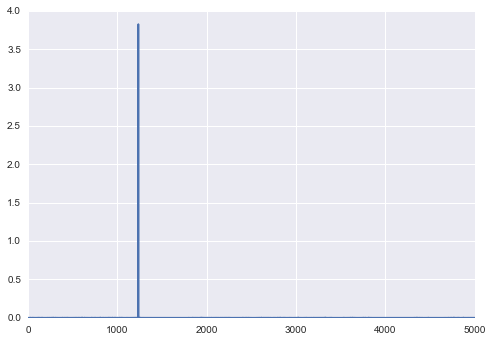

In [132]:
def _multitaper_fft(tapers, data, number_of_fft_samples, sampling_frequency):
    return scipy.fftpack.fft(tapers * data, n=number_of_fft_samples, axis=-1) / sampling_frequency

def _nextpower2(n):
    """Return the next integral power of two greater than the given number.
    Specifically, return m such that
        m >= n
        m == 2**x
    where x is an integer.
    This is useful for ensuring fast FFT sizes.
    """
    return int(2**np.ceil(np.log2(n)))

    
def multitaper_spectrum(data, sampling_frequency, desired_frequencies=None,
                        time_halfbandwidth_product=3, number_of_tapers=None, pad=0):
    if number_of_tapers is None:
        number_of_tapers = np.floor(2 * time_halfbandwidth_product - 1)
    if pad is None:
        pad = -1
    time_series_length = data.shape[0]
    number_of_fft_samples = max(_nextpower2(time_series_length) + pad, time_series_length)

    frequencies, freq_ind = _get_frequencies(sampling_frequency, number_of_fft_samples,
                                             desired_frequencies=desired_frequencies)
    tapers = _dpss(time_series_length, sampling_frequency, time_halfbandwidth_product, number_of_tapers)
    complex_spectrum = _multitaper_fft(tapers, data, number_of_fft_samples, sampling_frequency)
    return complex_spectrum, frequencies, freq_ind

def multitaper_power_spectral_density(data, sampling_frequency, desired_frequencies=None,
                        time_halfbandwidth_product=3, number_of_tapers=None, pad=0):
    complex_spectrum, frequencies, freq_ind = multitaper_spectrum(data, sampling_frequency,
                                                                  desired_frequencies=desired_frequencies,
                                                                  time_halfbandwidth_product=time_halfbandwidth_product,
                                                                  number_of_tapers=number_of_tapers)
    psd = np.real(np.conj(complex_spectrum[:, freq_ind]) * complex_spectrum[:, freq_ind])
    return np.mean(psd, axis=0).squeeze(), frequencies

# Test Signal
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
psd, frequencies = multitaper_power_spectral_density(x, fs)
plt.plot(frequencies, psd)

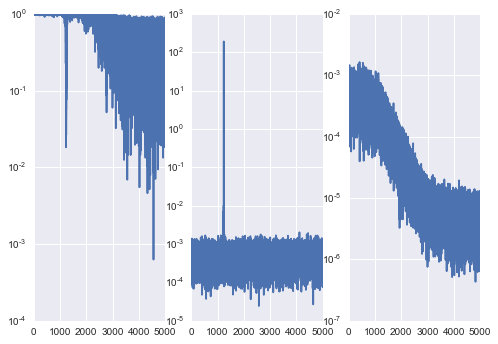

In [161]:
fs = 10e3
N = 1e5
amp = 20
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
b, a = scipy.signal.butter(2, 0.25, 'low')
x = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
y = scipy.signal.lfilter(b, a, x)
x += amp*np.sin(2*np.pi*freq*time)
y += np.random.normal(scale=0.1*np.sqrt(noise_power), size=time.shape)

mag, angle, freq = spectral.multitaper_coherency(x, y, fs)

fig = plt.figure()

ax1 = fig.add_subplot(131)
ax1.semilogy(freq, mag)

ax2 = fig.add_subplot(132)
psd, frequencies = multitaper_power_spectral_density(x, fs)
ax2.semilogy(frequencies, psd)

ax3 = fig.add_subplot(133)
psd, frequencies = multitaper_power_spectral_density(y, fs)
ax3.semilogy(frequencies, psd)